# GPT-4o Response Analysis

Investigating the high variance in GPT-4o responses compared to GPT-5 models.

In [1]:
import pandas as pd
import numpy as np
import json
import re
import matplotlib.pyplot as plt

# Load and parse data
df = pd.read_csv('model_responses.csv')

def extract_percentages(result_str):
    try:
        match = re.search(r'<answer>\s*(\{.*?\})\s*</answer>', result_str, re.DOTALL)
        if match:
            return json.loads(match.group(1))
    except:
        pass
    return None

df['percentages'] = df['result'].apply(extract_percentages)
df['blue_pct'] = df['percentages'].apply(lambda x: x.get('blue', np.nan) if x else np.nan)
df['purple_pct'] = df['percentages'].apply(lambda x: x.get('purple', np.nan) if x else np.nan)
df['red_pct'] = df['percentages'].apply(lambda x: x.get('red', np.nan) if x else np.nan)
df['green_pct'] = df['percentages'].apply(lambda x: x.get('green', np.nan) if x else np.nan)

# Apply color mapping for set 2
color_set_2 = "('green', 'red', 'purple', 'blue')"
mask_set2 = df['colors'] == color_set_2

df['blue_mapped'] = df['blue_pct'].copy()
df['purple_mapped'] = df['purple_pct'].copy()
df['red_mapped'] = df['red_pct'].copy()
df['green_mapped'] = df['green_pct'].copy()

df.loc[mask_set2, 'blue_mapped'] = df.loc[mask_set2, 'green_pct']
df.loc[mask_set2, 'purple_mapped'] = df.loc[mask_set2, 'red_pct']
df.loc[mask_set2, 'red_mapped'] = df.loc[mask_set2, 'purple_pct']
df.loc[mask_set2, 'green_mapped'] = df.loc[mask_set2, 'blue_pct']

print('Data loaded successfully')

Data loaded successfully


## 1. Distribution of Blue Container Responses by Model

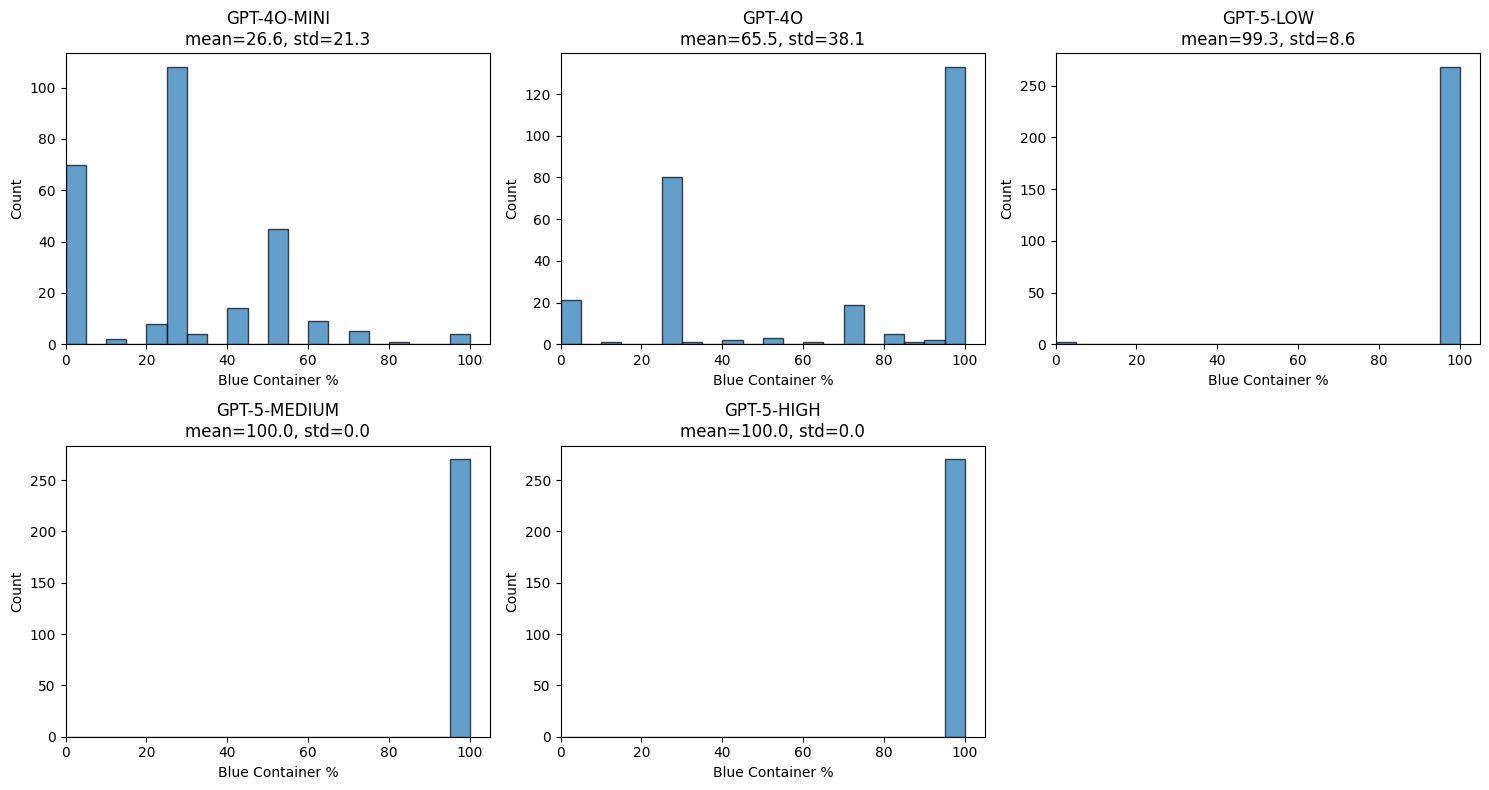

In [2]:
# Compare distributions across models
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
models = ['gpt-4o-mini', 'gpt-4o', 'gpt-5-low', 'gpt-5-medium', 'gpt-5-high']

for idx, model in enumerate(models):
    ax = axes[idx // 3, idx % 3]
    model_data = df[df['model'] == model]['blue_mapped'].dropna()
    ax.hist(model_data, bins=20, range=(0, 100), edgecolor='black', alpha=0.7)
    ax.set_title(f'{model.upper()}\nmean={model_data.mean():.1f}, std={model_data.std():.1f}')
    ax.set_xlabel('Blue Container %')
    ax.set_ylabel('Count')
    ax.set_xlim(0, 105)

axes[1, 2].axis('off')
plt.tight_layout()
plt.savefig('gpt4o_analysis_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

## 2. GPT-4o Response Patterns by Condition

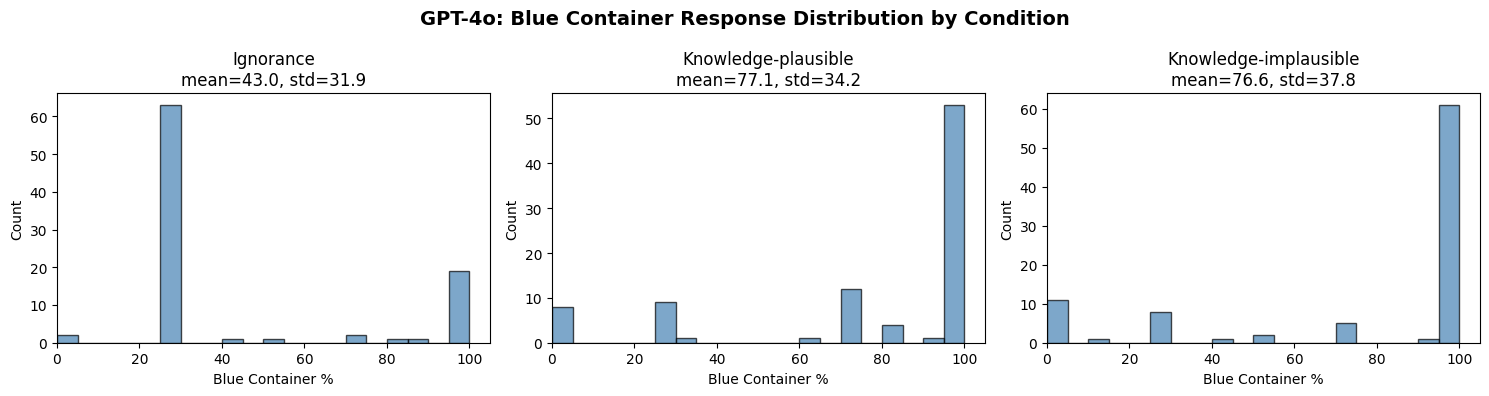

In [3]:
# GPT-4o distribution by condition
gpt4o = df[df['model'] == 'gpt-4o']

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
conditions = ['Ignorance', 'Knowledge-plausible', 'Knowledge-implausible']

for idx, cond in enumerate(conditions):
    ax = axes[idx]
    cond_data = gpt4o[gpt4o['condition'] == cond]['blue_mapped'].dropna()
    ax.hist(cond_data, bins=20, range=(0, 100), edgecolor='black', alpha=0.7, color='steelblue')
    ax.set_title(f'{cond}\nmean={cond_data.mean():.1f}, std={cond_data.std():.1f}')
    ax.set_xlabel('Blue Container %')
    ax.set_ylabel('Count')
    ax.set_xlim(0, 105)

plt.suptitle('GPT-4o: Blue Container Response Distribution by Condition', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('gpt4o_analysis_by_condition.png', dpi=150, bbox_inches='tight')
plt.show()

## 3. Categorize GPT-4o Response Types

In [4]:
# Categorize response types
def categorize_response(blue_pct):
    if pd.isna(blue_pct):
        return 'Invalid'
    elif blue_pct >= 95:
        return 'Correct (100%)'
    elif 20 <= blue_pct <= 30:
        return 'Uniform (25%)'
    elif blue_pct <= 5:
        return 'Wrong (0%)'
    else:
        return 'Other'

gpt4o = df[df['model'] == 'gpt-4o'].copy()
gpt4o['response_type'] = gpt4o['blue_mapped'].apply(categorize_response)

# Count by condition
response_counts = gpt4o.groupby(['condition', 'response_type']).size().unstack(fill_value=0)
print('GPT-4o Response Type Counts by Condition:')
print('='*60)
display(response_counts)

# Percentage
response_pct = response_counts.div(response_counts.sum(axis=1), axis=0) * 100
print('\nGPT-4o Response Type Percentages by Condition:')
print('='*60)
display(response_pct.round(1))

GPT-4o Response Type Counts by Condition:


response_type,Correct (100%),Invalid,Other,Uniform (25%),Wrong (0%)
condition,,,,,
Ignorance,19,0,6,63,2
Knowledge-implausible,61,0,10,8,11
Knowledge-plausible,53,1,18,10,8



GPT-4o Response Type Percentages by Condition:


response_type,Correct (100%),Invalid,Other,Uniform (25%),Wrong (0%)
condition,,,,,
Ignorance,21.1,0.0,6.7,70.0,2.2
Knowledge-implausible,67.8,0.0,11.1,8.9,12.2
Knowledge-plausible,58.9,1.1,20.0,11.1,8.9


In [5]:
# Breakdown by Color Mapping
print("GPT-4o Response Types by Color Set")
print("="*70)

gpt4o = df[df['model'] == 'gpt-4o'].copy()
gpt4o['response_type'] = gpt4o['blue_mapped'].apply(categorize_response)
gpt4o['color_set'] = gpt4o['colors'].apply(lambda x: 'Set 1 (blue first)' if 'blue' in x[:20] else 'Set 2 (green first)')

# Count by color set and response type
color_breakdown = gpt4o.groupby(['color_set', 'response_type']).size().unstack(fill_value=0)
print("\nCounts:")
display(color_breakdown)

# Percentage
color_pct = color_breakdown.div(color_breakdown.sum(axis=1), axis=0) * 100
print("\nPercentages:")
display(color_pct.round(1))

# Also show by condition within each color set
print("\n" + "="*70)
print("Breakdown by Color Set AND Condition:")
print("="*70)
for color_set in ['Set 1 (blue first)', 'Set 2 (green first)']:
    print(f"\n--- {color_set} ---")
    subset = gpt4o[gpt4o['color_set'] == color_set]
    breakdown = subset.groupby(['condition', 'response_type']).size().unstack(fill_value=0)
    display(breakdown)

GPT-4o Response Types by Color Set

Counts:


response_type,Correct (100%),Invalid,Other,Uniform (25%),Wrong (0%)
color_set,,,,,
Set 1 (blue first),65,1,16,44,9
Set 2 (green first),68,0,18,37,12



Percentages:


response_type,Correct (100%),Invalid,Other,Uniform (25%),Wrong (0%)
color_set,,,,,
Set 1 (blue first),48.1,0.7,11.9,32.6,6.7
Set 2 (green first),50.4,0.0,13.3,27.4,8.9



Breakdown by Color Set AND Condition:

--- Set 1 (blue first) ---


response_type,Correct (100%),Invalid,Other,Uniform (25%),Wrong (0%)
condition,,,,,
Ignorance,8,0,2,33,2
Knowledge-implausible,33,0,4,6,2
Knowledge-plausible,24,1,10,5,5



--- Set 2 (green first) ---


response_type,Correct (100%),Other,Uniform (25%),Wrong (0%)
condition,,,,
Ignorance,11,4,30,0
Knowledge-implausible,28,6,2,9
Knowledge-plausible,29,8,5,3


## 4. Detailed Case Analysis

In [6]:
# Show ALL Wrong (0%) cases for GPT-4o, grouped by condition
print("="*100)
print("ALL GPT-4o Cases with 0% Blue (Wrong Responses) - Grouped by Condition")
print("="*100)

wrong_cases = gpt4o[gpt4o['response_type'] == 'Wrong (0%)'].copy()
print(f"\nTotal: {len(wrong_cases)} cases\n")

for condition in ['Ignorance', 'Knowledge-plausible', 'Knowledge-implausible']:
    cond_cases = wrong_cases[wrong_cases['condition'] == condition]
    print(f"\n{'#'*100}")
    print(f"# {condition.upper()} ({len(cond_cases)} cases)")
    print(f"{'#'*100}")
    
    for idx, (_, row) in enumerate(cond_cases.iterrows(), 1):
        print(f"\n{'='*100}")
        print(f"CASE {idx}/{len(cond_cases)} - {condition}")
        print(f"{'='*100}")
        print(f"Names: {row['names']}")
        print(f"Colors: {row['colors']}")
        print(f"Trial: {row['trial']}")
        print(f"\nRaw percentages: blue={row['blue_pct']}, purple={row['purple_pct']}, red={row['red_pct']}, green={row['green_pct']}")
        print(f"Mapped percentages: blue={row['blue_mapped']}, purple={row['purple_mapped']}, red={row['red_mapped']}, green={row['green_mapped']}")
        print(f"\n--- FULL RESPONSE ---")
        print(row['result'])

ALL GPT-4o Cases with 0% Blue (Wrong Responses) - Grouped by Condition

Total: 21 cases


####################################################################################################
# IGNORANCE (2 cases)
####################################################################################################

CASE 1/2 - Ignorance
Names: ('Alice', 'Beth')
Colors: ('blue', 'purple', 'red', 'green')
Trial: 4

Raw percentages: blue=0.0, purple=33.33, red=33.33, green=33.33
Mapped percentages: blue=0.0, purple=33.33, red=33.33, green=33.33

--- FULL RESPONSE ---
To determine the chances of Alice finding the violin on her first attempt, we assume she has no knowledge of the changes made by Beth.

Originally, the containers were in the order: blue, purple, red, green. Alice placed her violin in the blue container.

Beth moved the violin to another container. There are three possibilities for where the violin could be now (since it was moved from blue):

1. Purple container
2. Red containe

In [7]:
# Show ALL Uniform (25%) cases for GPT-4o, grouped by condition
print("="*100)
print("ALL GPT-4o Cases with ~25% Each (Uniform Responses) - Grouped by Condition")
print("="*100)

uniform_cases = gpt4o[gpt4o['response_type'] == 'Uniform (25%)'].copy()
print(f"\nTotal: {len(uniform_cases)} cases\n")

for condition in ['Ignorance', 'Knowledge-plausible', 'Knowledge-implausible']:
    cond_cases = uniform_cases[uniform_cases['condition'] == condition]
    print(f"\n{'#'*100}")
    print(f"# {condition.upper()} ({len(cond_cases)} cases)")
    print(f"{'#'*100}")
    
    for idx, (_, row) in enumerate(cond_cases.iterrows(), 1):
        print(f"\n{'='*100}")
        print(f"CASE {idx}/{len(cond_cases)} - {condition}")
        print(f"{'='*100}")
        print(f"Names: {row['names']}")
        print(f"Colors: {row['colors']}")
        print(f"Trial: {row['trial']}")
        print(f"\nRaw percentages: blue={row['blue_pct']}, purple={row['purple_pct']}, red={row['red_pct']}, green={row['green_pct']}")
        print(f"Mapped percentages: blue={row['blue_mapped']}, purple={row['purple_mapped']}, red={row['red_mapped']}, green={row['green_mapped']}")
        print(f"\n--- FULL RESPONSE ---")
        print(row['result'])

ALL GPT-4o Cases with ~25% Each (Uniform Responses) - Grouped by Condition

Total: 81 cases


####################################################################################################
# IGNORANCE (63 cases)
####################################################################################################

CASE 1/63 - Ignorance
Names: ('Alice', 'Beth')
Colors: ('blue', 'purple', 'red', 'green')
Trial: 0

Raw percentages: blue=25.0, purple=25.0, red=25.0, green=25.0
Mapped percentages: blue=25.0, purple=25.0, red=25.0, green=25.0

--- FULL RESPONSE ---
To solve this problem, we need to consider Alice’s perspective and understanding of the situation when she returns:

1. **Initial State:** Alice knows she left her violin in the blue container.
2. **After Beth’s Action:** Alice is unaware of Beth’s actions. She doesn't know that her violin was moved or that the containers' positions were swapped.

From Alice's perspective, all containers have an equal chance of containing her 

In [8]:
# Sample Other (weird) and Correct (100%) cases by condition - FULL RESPONSES
print("="*100)
print("SAMPLE GPT-4o Cases: Other (Weird) and Correct (100%) - By Condition - FULL RESPONSES")
print("="*100)

for response_type in ['Other', 'Correct (100%)']:
    print(f"\n{'#'*100}")
    print(f"# {response_type.upper()} CASES")
    print(f"{'#'*100}")
    
    type_cases = gpt4o[gpt4o['response_type'] == response_type]
    
    for condition in ['Ignorance', 'Knowledge-plausible', 'Knowledge-implausible']:
        cond_cases = type_cases[type_cases['condition'] == condition]
        print(f"\n--- {condition} ({len(cond_cases)} total cases) ---")
        
        if len(cond_cases) == 0:
            print("No cases")
            continue
        
        # Show up to 3 samples per condition with FULL responses
        for idx, (_, row) in enumerate(cond_cases.head(3).iterrows(), 1):
            print(f"\n{'='*80}")
            print(f"Sample {idx}:")
            print(f"{'='*80}")
            print(f"Colors: {row['colors']}")
            print(f"Mapped: blue={row['blue_mapped']}, purple={row['purple_mapped']}, red={row['red_mapped']}, green={row['green_mapped']}")
            print(f"\n--- FULL RESPONSE ---")
            print(row['result'])

SAMPLE GPT-4o Cases: Other (Weird) and Correct (100%) - By Condition - FULL RESPONSES

####################################################################################################
# OTHER CASES
####################################################################################################

--- Ignorance (6 total cases) ---

Sample 1:
Colors: ('blue', 'purple', 'red', 'green')
Mapped: blue=50.0, purple=16.67, red=16.67, green=16.67

--- FULL RESPONSE ---
To solve this, let's consider Alice's perspective without knowledge of the changes:

1. Alice initially knows her ball is in the blue container.
2. The containers are now ordered as red, green, purple, and blue (left to right).

Since Alice is unaware of the changes and believes the ball is still in the blue container’s new position, she will most likely look there first.

Given her belief that the ball is in the blue container:

1. She will look in the blue container first with the highest likelihood.
2. After not finding 

GPT-4o vs GPT-4o-mini: Response Types by Condition

GPT-4o Response Type Summary:
response_type
Correct (100%)    133
Uniform (25%)      81
Other              34
Wrong (0%)         21
Invalid             1
Name: count, dtype: int64

GPT-4o-mini Response Type Summary:
response_type
Uniform (25%)     120
Other              76
Wrong (0%)         70
Correct (100%)      4
Name: count, dtype: int64

Detailed Breakdown by Condition

################################################################################
# IGNORANCE
################################################################################

--- GPT-4o (n=90) ---
  Correct (100%)      :  19 ( 21.1%)
  Uniform (25%)       :  63 ( 70.0%)
  Wrong (0%)          :   2 (  2.2%)
  Other               :   6 (  6.7%)
  Invalid             :   0 (  0.0%)

--- GPT-4o-mini (n=90) ---
  Correct (100%)      :   2 (  2.2%)
  Uniform (25%)       :  20 ( 22.2%)
  Wrong (0%)          :  61 ( 67.8%)
  Other               :   7 (  7.8%)
  Invalid   

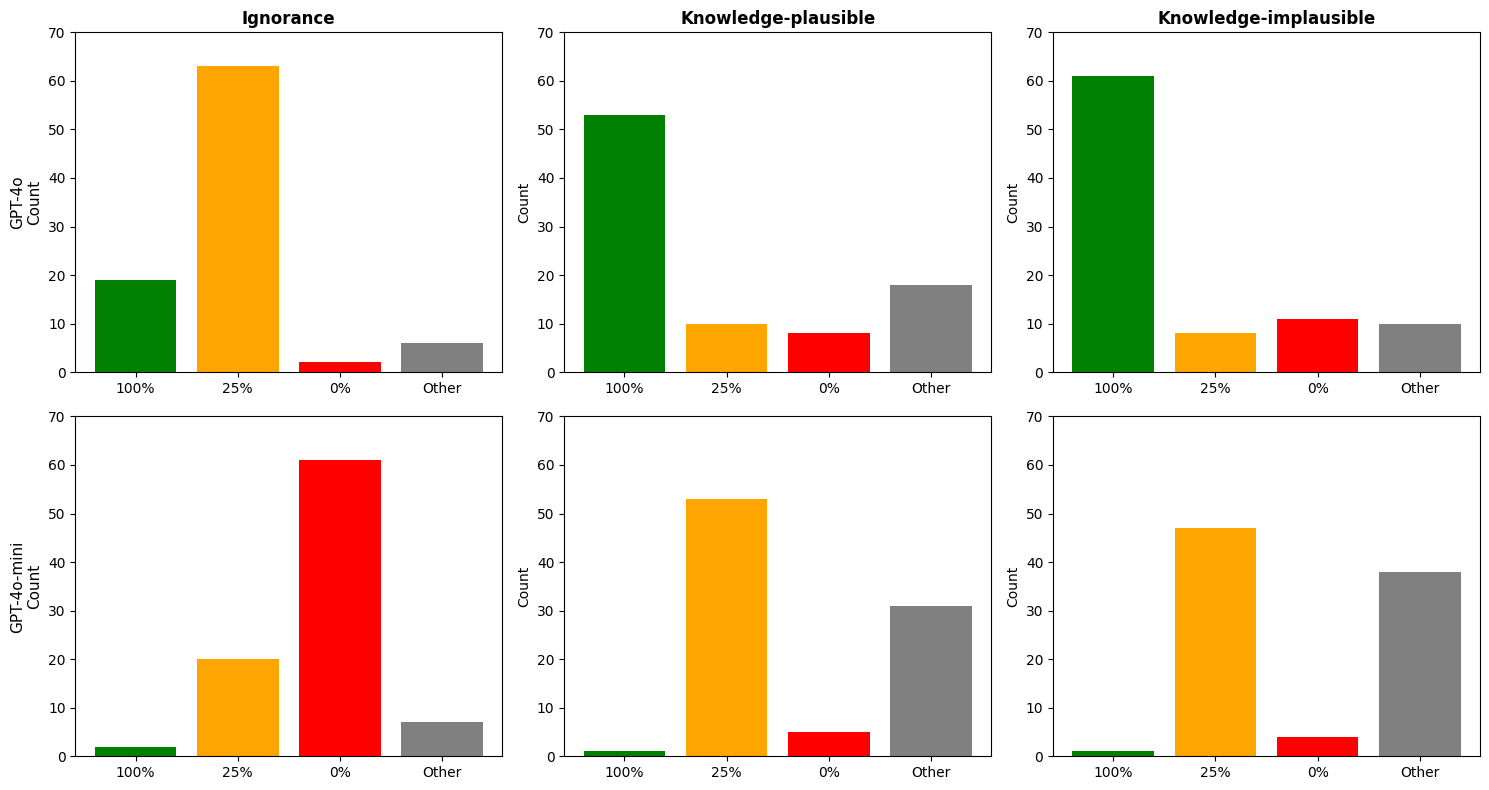

In [9]:
# Compare GPT-4o and GPT-4o-mini by condition
gpt4o_mini = df[df['model'] == 'gpt-4o-mini'].copy()
gpt4o_mini['response_type'] = gpt4o_mini['blue_mapped'].apply(categorize_response)

print("="*100)
print("GPT-4o vs GPT-4o-mini: Response Types by Condition")
print("="*100)

# Summary counts
print("\nGPT-4o Response Type Summary:")
print(gpt4o['response_type'].value_counts())
print("\nGPT-4o-mini Response Type Summary:")
print(gpt4o_mini['response_type'].value_counts())

# Breakdown by condition for both models
print("\n" + "="*100)
print("Detailed Breakdown by Condition")
print("="*100)

for condition in ['Ignorance', 'Knowledge-plausible', 'Knowledge-implausible']:
    print(f"\n{'#'*80}")
    print(f"# {condition.upper()}")
    print(f"{'#'*80}")
    
    for model_name, model_data in [('GPT-4o', gpt4o), ('GPT-4o-mini', gpt4o_mini)]:
        cond_data = model_data[model_data['condition'] == condition]
        counts = cond_data['response_type'].value_counts()
        total = len(cond_data)
        
        print(f"\n--- {model_name} (n={total}) ---")
        for resp_type in ['Correct (100%)', 'Uniform (25%)', 'Wrong (0%)', 'Other', 'Invalid']:
            count = counts.get(resp_type, 0)
            pct = (count / total * 100) if total > 0 else 0
            print(f"  {resp_type:20}: {count:3} ({pct:5.1f}%)")

# Visual comparison
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
conditions = ['Ignorance', 'Knowledge-plausible', 'Knowledge-implausible']
response_types = ['Correct (100%)', 'Uniform (25%)', 'Wrong (0%)', 'Other']
colors = ['green', 'orange', 'red', 'gray']

for col, condition in enumerate(conditions):
    for row, (model_name, model_data) in enumerate([('GPT-4o', gpt4o), ('GPT-4o-mini', gpt4o_mini)]):
        ax = axes[row, col]
        cond_data = model_data[model_data['condition'] == condition]
        counts = [cond_data[cond_data['response_type'] == rt].shape[0] for rt in response_types]
        
        ax.bar(range(len(response_types)), counts, color=colors)
        ax.set_xticks(range(len(response_types)))
        ax.set_xticklabels(['100%', '25%', '0%', 'Other'], rotation=0)
        ax.set_ylabel('Count')
        ax.set_ylim(0, 70)
        
        if row == 0:
            ax.set_title(f'{condition}', fontsize=12, fontweight='bold')
        if col == 0:
            ax.set_ylabel(f'{model_name}\nCount', fontsize=11)

plt.tight_layout()
plt.savefig('gpt4o_analysis_response_types.png', dpi=150, bbox_inches='tight')
plt.show()

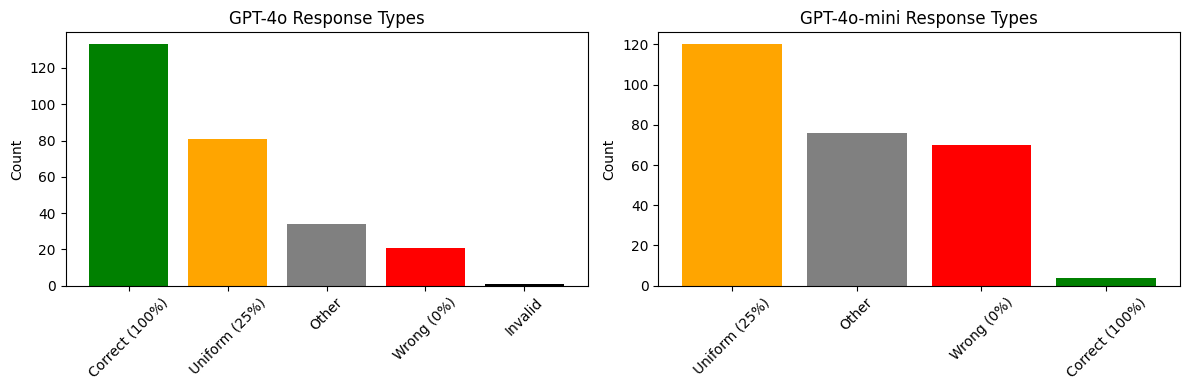


GPT-4o Response Type Summary:
response_type
Correct (100%)    133
Uniform (25%)      81
Other              34
Wrong (0%)         21
Invalid             1
Name: count, dtype: int64

GPT-4o-mini Response Type Summary:
response_type
Uniform (25%)     120
Other              76
Wrong (0%)         70
Correct (100%)      4
Name: count, dtype: int64


In [10]:
# Compare GPT-4o and GPT-4o-mini
gpt4o_mini = df[df['model'] == 'gpt-4o-mini'].copy()
gpt4o_mini['response_type'] = gpt4o_mini['blue_mapped'].apply(categorize_response)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for idx, (model_name, model_data) in enumerate([('GPT-4o', gpt4o), ('GPT-4o-mini', gpt4o_mini)]):
    ax = axes[idx]
    counts = model_data['response_type'].value_counts()
    color_map = {'Correct (100%)': 'green', 'Uniform (25%)': 'orange', 'Wrong (0%)': 'red', 'Other': 'gray', 'Invalid': 'black'}
    ax.bar(counts.index, counts.values, color=[color_map.get(x, 'gray') for x in counts.index])
    ax.set_title(f'{model_name} Response Types')
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('gpt4o_analysis_response_types.png', dpi=150, bbox_inches='tight')
plt.show()

print('\nGPT-4o Response Type Summary:')
print(gpt4o['response_type'].value_counts())
print('\nGPT-4o-mini Response Type Summary:')
print(gpt4o_mini['response_type'].value_counts())

In [11]:
# Show GPT-4o-mini Wrong (0%) cases to compare error patterns - FULL RESPONSES
print("="*100)
print("GPT-4o-mini Wrong (0%) Cases - Grouped by Condition - FULL RESPONSES")
print("="*100)

gpt4o_mini_wrong = gpt4o_mini[gpt4o_mini['response_type'] == 'Wrong (0%)'].copy()
print(f"\nTotal: {len(gpt4o_mini_wrong)} cases\n")

for condition in ['Ignorance', 'Knowledge-plausible', 'Knowledge-implausible']:
    cond_cases = gpt4o_mini_wrong[gpt4o_mini_wrong['condition'] == condition]
    print(f"\n{'#'*100}")
    print(f"# {condition.upper()} ({len(cond_cases)} cases)")
    print(f"{'#'*100}")

    # Show ALL cases with FULL responses
    for idx, (_, row) in enumerate(cond_cases.iterrows(), 1):
        print(f"\n{'='*80}")
        print(f"CASE {idx}/{len(cond_cases)}")
        print(f"{'='*80}")
        print(f"Colors: {row['colors']}")
        print(f"Trial: {row['trial']}")
        print(f"Mapped: blue={row['blue_mapped']}, purple={row['purple_mapped']}, red={row['red_mapped']}, green={row['green_mapped']}")
        print(f"\n--- FULL RESPONSE ---")
        print(row['result'])

GPT-4o-mini Wrong (0%) Cases - Grouped by Condition - FULL RESPONSES

Total: 70 cases


####################################################################################################
# IGNORANCE (61 cases)
####################################################################################################

CASE 1/61
Colors: ('blue', 'purple', 'red', 'green')
Trial: 0
Mapped: blue=0.0, purple=33.33, red=33.34, green=33.33

--- FULL RESPONSE ---
To determine Alice's chances of looking for the violin in each container, we need to analyze her thought process and the events that occurred.

1. **Initial Placement**: Alice puts her violin in the blue container.
2. **Movement by Beth**: Beth then moves the violin to one of the other containers (purple, red, or green). Since there's no indication of Beth's choice, we can consider that the violin is equally likely to be in any of the three remaining containers:
   - Green
   - Purple
   - Red

Thus, before the container swap, the probabili

## 6. Key Findings

### Response Type Distribution

1. **GPT-4o shows bimodal behavior**: Some responses give 100% to blue (correct false-belief reasoning), while others give ~25% (uniform distribution suggesting no ToM reasoning).

2. **GPT-4o-mini is even more variable**: Shows more uniform/wrong responses than GPT-4o.

3. **GPT-5 models are consistent**: Nearly all responses give 100% to blue, showing robust false-belief reasoning.

### Two Distinct Error Patterns: GPT-4o vs GPT-4o-mini

#### GPT-4o-mini in Ignorance: "Reality-Tracking" Error
- **Pattern**: 0% blue, 33% each to purple/red/green (uniform over possible locations)
- **Reasoning**: "The violin was moved to one of the other containers. There are 3 possibilities..."
- **What the model answers**: "Where COULD the object be now?" (tracks reality/possibilities)
- **What it should answer**: "Where does Alice BELIEVE it is?" (tracks her belief)

*Example*: "Blue: 0% (the violin is no longer there), Purple: 33%, Red: 33%, Green: 33%"

#### GPT-4o in Knowledge Conditions: "Location-vs-Identity" Error
- **Pattern**: 0% blue, 100% to ONE wrong container (the one in blue's original position)
- **Reasoning**: "Alice will look where the blue container WAS, not where it IS now"
- **What the model assumes**: Characters track SPATIAL POSITION ("the leftmost spot")
- **What humans actually do**: Track CONTAINER IDENTITY ("the blue box")

*Example*: "Alice will look in the first position from left, which is now the red container... red: 100%"

### Error Pattern Summary by Condition

| Condition | GPT-4o Error Pattern | GPT-4o-mini Error Pattern |
|-----------|---------------------|---------------------------|
| Ignorance | Rare (2.2%) - Reality-tracking | Very common (67.8%) - Reality-tracking |
| Knowledge-Plausible | Location-vs-identity (8.9%) | Less common - Mixed |
| Knowledge-Implausible | Location-vs-identity (12.2%) | Less common - Mixed |

### Key Distinction

- **GPT-4o-mini's error** is about **what the object's current state is** (reality-tracking) - it distributes probability uniformly over where the object COULD be, ignoring Alice's belief entirely.

- **GPT-4o's error** is about **how characters track objects** (position vs identity) - it assumes Alice memorizes POSITIONS ("first from left") rather than recognizing CONTAINERS by color.

Both errors represent failures of Theory of Mind, but through different mechanisms:
- GPT-4o-mini: Fails to model Alice's belief state at all
- GPT-4o: Models Alice having a belief, but about the wrong thing (position instead of object)

### Why GPT-5 Succeeds

GPT-5 never makes either error - it consistently understands:
1. Alice has a **belief** about where her violin is (not just reality)
2. That belief is about the **blue container** itself (not its position)
3. The belief persists even after containers are rearranged